In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#!/usr/bin/env python3
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsp
from jax import Array, grad, jit, random, vmap
from jax.random import PRNGKey
from jax.scipy.stats import norm

from bpd.chains import run_inference_nuts
from bpd.prior import ellip_prior_e1e2
from bpd.sample import sample_ellip_prior
from bpd.shear import (
    inv_shear_func1,
    inv_shear_func2,
    inv_shear_transformation,
    shear_transformation,
)
from bpd.utils import uniform_logpdf

eta_inv_fnc1 = lambda eta: eta2g(eta)[0]
eta_inv_fnc2 = lambda eta: eta2g(eta)[1]

grad_fnc1 = grad(eta_inv_fnc1)
grad_fnc2 = grad(eta_inv_fnc2)


def eta2g(eta: Array):
    assert eta.shape == (2,)
    eta1 = eta[0]
    eta2 = eta[1]
    abseta = jnp.sqrt(eta1**2 + eta2**2)
    g1 = eta1 * jnp.tanh(0.5 * abseta) / abseta
    g2 = eta2 * jnp.tanh(0.5 * abseta) / abseta
    return jnp.array([g1, g2])


def g2eta(g: Array):
    assert g.shape == (2,)
    g1 = g[0]
    g2 = g[1]
    absg = jnp.sqrt(g1**2 + g2**2)
    eta1 = g1 * jnp.arctanh(absg) * 2 / absg
    eta2 = g2 * jnp.arctanh(absg) * 2 / absg
    return jnp.array([eta1, eta2])


def sample_noisy_eta(rng_key, *, g, sigma_e: float, sigma_m: float, n: int = 1):
    k1, k2 = random.split(rng_key)
    es = sample_ellip_prior(k1, sigma_e, n)
    essh = shear_transformation(es, g)
    etas = vmap(g2eta)(essh)
    noisy_etas = etas.reshape(n, 2) + random.normal(k2, shape=(n, 2)) * sigma_m
    return noisy_etas, etas


def eta_target(eta, *, data, sigma_e: float, sigma_m: float):
    neta = data
    llike = norm.logpdf(neta, loc=eta, scale=sigma_m).sum()

    e1e2 = eta2g(eta)
    lprior1 = jnp.log(ellip_prior_e1e2(e1e2, sigma_e))

    grad1 = grad_fnc1(eta)
    grad2 = grad_fnc2(eta)
    prior2 = jnp.abs(grad1[..., 0] * grad2[..., 1] - grad1[..., 1] * grad2[..., 0])
    lprior2 = jnp.log(prior2)

    return llike + lprior1 + lprior2


_grad_shear_fnc1 = vmap(
    vmap(grad(inv_shear_func1), in_axes=(0, None)), in_axes=(0, None)
)
_grad_shear_fnc2 = vmap(
    vmap(grad(inv_shear_func2), in_axes=(0, None)), in_axes=(0, None)
)

# already vmapped once
_inv_shear_trans = vmap(inv_shear_transformation, in_axes=(0, None))


def shear_eta_target(g, *, data, sigma_e: float, sigma_e_int: float):
    assert g.shape == (2,)
    assert data.ndim == 3 and data.shape[2] == 2
    etas = data

    # P(eta' | alpha, g) = P(eps | alpha) * (del eps' / del eta') * (del eps / del eps')
    # jacobian on eta cancels between num and denom so we ignore it.
    eps_sheared = vmap(vmap(eta2g))(etas)
    eps = _inv_shear_trans(eps_sheared, g)
    num1 = jnp.log(ellip_prior_e1e2(eps, sigma_e))

    grad_eps1 = _grad_shear_fnc1(eps_sheared, g)
    grad_eps2 = _grad_shear_fnc2(eps_sheared, g)
    jac = jnp.abs(
        grad_eps1[..., 0] * grad_eps2[..., 1] - grad_eps1[..., 1] * grad_eps2[..., 0]
    )
    num2 = jnp.log(jac)

    num = num1 + num2

    # now denom P0(eta') = P0(eps') * (del eps' / del eta')
    denom = jnp.log(ellip_prior_e1e2(eps_sheared, sigma_e_int))

    # ratio
    ratio = jsp.special.logsumexp(num - denom, axis=-1)
    loglike = ratio.sum()

    # prior on shear
    g_mag = jnp.sqrt(g[0] ** 2 + g[1] ** 2)
    logprior = uniform_logpdf(g_mag, 0.0, 1.0) + jnp.log(1 / (2 * jnp.pi))

    return logprior + loglike


def run_one_eta_experiment(
    rng_key: PRNGKey,
    true_g,
    *,
    n_gals: int,
    n_samples_per_gal: int,
    n_samples_shear: int,
    sigma_e: float,
    sigma_e_int: float,
    sigma_m: float,
):
    k1, k2, k3 = random.split(rng_key, 3)

    # generate data
    netas, etas = sample_noisy_eta(
        k1, g=true_g, sigma_e=sigma_e, sigma_m=sigma_m, n=n_gals
    )

    # run phase 1
    target1 = partial(eta_target, sigma_e=sigma_e_int, sigma_m=sigma_m)
    pipe1 = partial(
        run_inference_nuts,
        logtarget=target1,
        n_samples=n_samples_per_gal,
        initial_step_size=0.01,
        max_num_doublings=2,
    )
    pipe1 = vmap(jit(pipe1))
    k2s = random.split(k2, n_gals)
    eta_samples = pipe1(k2s, netas, etas)

    # run phase 2
    target2 = partial(shear_eta_target, sigma_e=sigma_e, sigma_e_int=sigma_e_int)
    pipe2 = partial(
        run_inference_nuts,
        logtarget=target2,
        n_samples=n_samples_shear,
        initial_step_size=0.01,
        max_num_doublings=2,
    )
    pipe2 = jit(pipe2)

    g_samples = pipe2(k3, eta_samples, true_g)
    return g_samples


In [9]:
# draw shear samples from prior (unit disk)
def sample_shear_prior(rng_key):
    k1, k2 = random.split(rng_key)
    g_mag = random.uniform(k1, minval=-0.1, maxval=0.1)
    theta = random.uniform(k2, minval=0, maxval=jnp.pi)
    g1 = g_mag * jnp.cos(2 * theta)
    g2 = g_mag * jnp.sin(2 * theta)
    return jnp.array([g1,g2])
    

In [10]:
n_exps = 1_000
k = random.key(42)
k1, k2 = random.split(k)
k1s = random.split(k1, n_exps)
k2s = random.split(k2, n_exps)

In [5]:
pipe = partial(run_one_eta_experiment, n_gals=1000, n_samples_per_gal=300, n_samples_shear=1024-1, sigma_e=0.2, sigma_e_int=0.3, sigma_m=0.3)
pipe = jit(pipe)

In [6]:
# run once (jitting)
_ = pipe(k1s[0], jnp.array([0.02, 0.0]))

In [11]:
gs = vmap(sample_shear_prior)(k1s)
gs.shape

(500, 2)

In [8]:
from bpd.utils import process_in_batches
g_samples = process_in_batches(vmap(pipe), k2s, gs, n_points=n_exps, batch_size = 100, )

Processing batches: 100%|██████████| 5/5 [05:57<00:00, 71.56s/it]


In [54]:
# # now vectorize
# g_samples = vmap(pipe)(k2s, gs)

In [9]:
g_samples.shape

(500, 1023, 2)

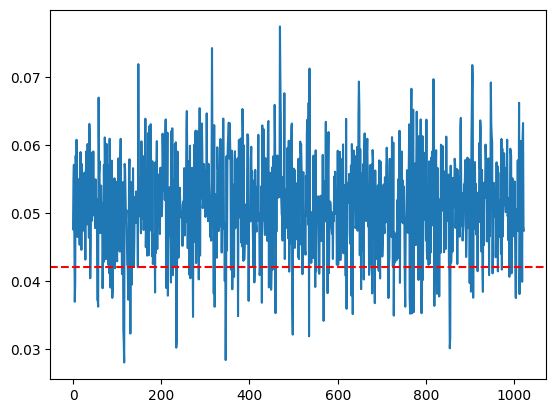

In [10]:
plt.plot(g_samples[3, :, 0])
plt.axhline(gs[3, 0], c='r', ls='--')

# Saving and Loading

In [16]:
jnp.save("eta_samples.npy", g_samples, allow_pickle=False)

In [6]:
g_samples = jnp.load("eta_samples.npy")
g_samples.shape

(500, 1023, 2)

# Posterior calibration results

In [12]:
from bpd.diagnostics import get_pc_fig

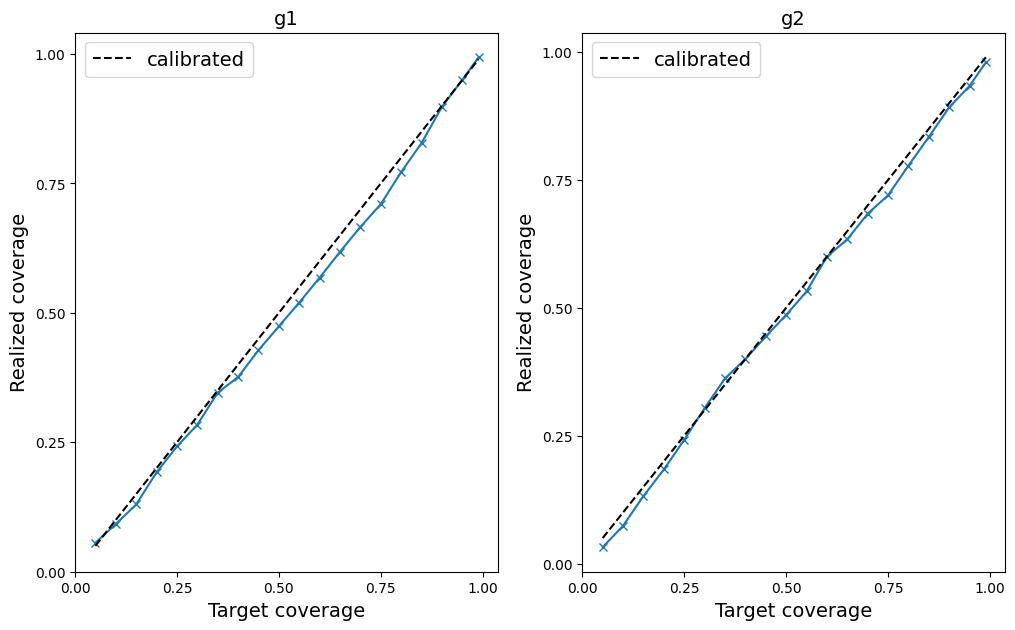

In [261]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,7))

g1_samples = g_samples[:, :, 0]
g1_truth = gs[:, 0]

get_pc_fig(ax1, g1_samples, g1_truth, param_name='g1')


g2_samples = g_samples[:, :,1]
g2_truth = gs[:, 1]

get_pc_fig(ax2, g2_samples, g2_truth, param_name='g2')


# Rank results (Talts et al.)

In [427]:
from scipy.stats import binom
import numpy as np 

In [428]:
g1_samples = g_samples[:, :, 0]
g1_truth = gs[:, 0].reshape(-1, 1)

ranks1 = np.sum( (g1_samples < g1_truth), axis=1)
ranks1.shape, g1_samples.shape

((500,), (500, 1023))

In [429]:
# ranks1 = np.random.randint(low=0, high=1023, size=(10_000,))

In [430]:
# # compute deviation as percentiles of Binomial(N, (L+1)^-1)
# binom.ppf(0.005, n=n_exps, p=(100+1)**-1)


In [431]:
_, bins = np.histogram(ranks1, bins=21)

In [432]:
from numpy.random import randint
high = g1_samples.shape[-1]
boot_ranks = randint(low = 0, high = high, size=(10_000, ranks1.shape[0]))
# low_boot = np.quantile(boot_ranks, 0.005, axis=0)
# high_boot = np.quantile(boot_ranks, 0.995, axis=0)
# low_boot, high_boot

In [433]:
hists = []
ecdfs = []
for ii in range(len(boot_ranks)):
    hist, _ = np.histogram(boot_ranks[ii], bins=bins)

    hist_normed, _ = np.histogram(boot_ranks[ii], bins=bins, density=True)
    ecdf = np.cumsum(hist_normed)
    ecdf /= ecdf[-1]
    
    hists.append(hist)
    ecdfs.append(ecdf)
                        
hists = np.stack(hists, axis=0)
ecdfs = np.stack(ecdfs, axis=0)

In [434]:
hists.shape, ecdfs.shape

((10000, 21), (10000, 21))

In [435]:
low = np.quantile(hists, 0.005, axis=0)
median = np.quantile(hists, 0.5, axis=0)
high = np.quantile(hists, 0.995, axis=0 )

In [436]:
low_ecdf = np.quantile(ecdfs, 0.005, axis=0)
median_ecdf = np.quantile(ecdfs, 0.5, axis=0)
high_ecdf = np.quantile(ecdfs, 0.995, axis=0 )

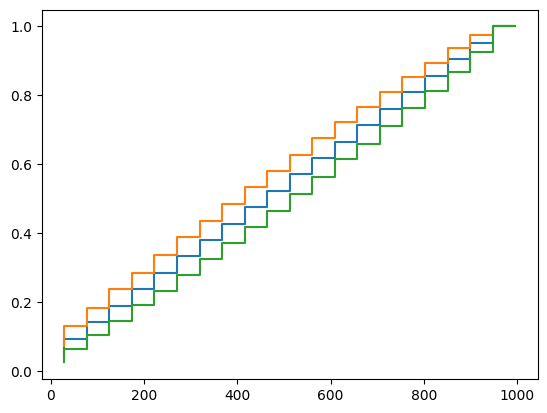

In [437]:
meds = (bins[1:] + bins[:-1]) / 2
plt.step(meds, median_ecdf)
plt.step(meds, high_ecdf)
plt.step(meds, low_ecdf)

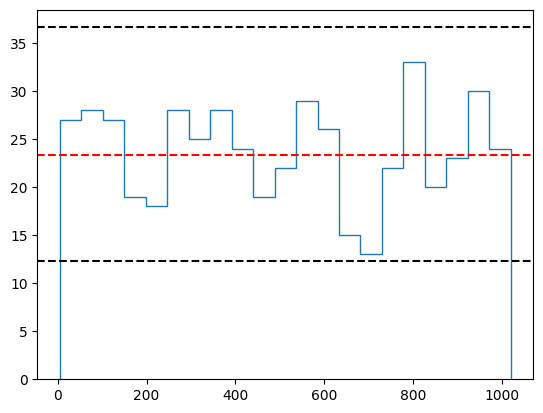

In [438]:
plt.hist(ranks1, bins=bins, histtype='step')
plt.axhline(low.mean(), c='k', ls='--')
plt.axhline(high.mean(), c='k', ls='--')
plt.axhline(median.mean(), c='r', ls='--')

In [439]:
# vals, _ = np.histogram(ranks1, bins=bins, density=True)
# np.cumsum(vals)

In [440]:
# vals, bins = np.histogram(ranks1, bins=bins, density=True)
# np.cumsum(vals) / np.cumsum(vals)[-1]

In [441]:
mids.shape

(21,)

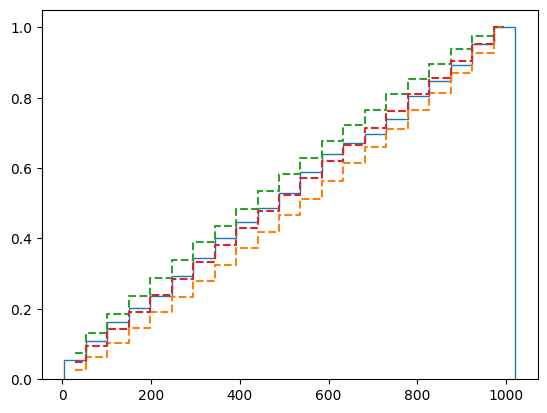

In [442]:
# ECDF analysis
mids = (bins[1:] + bins[:-1]) / 2
vals, _, _ =plt.hist(ranks1, bins=bins, histtype='step', cumulative=True, density=True)
plt.step(mids, low_ecdf, where='mid', ls='--')
plt.step(mids, high_ecdf, where='mid', ls='--')
plt.step(mids, median_ecdf, where='mid', ls='--')
# plt.hist(low, bins=bins, histtype='step', cumulative=True)

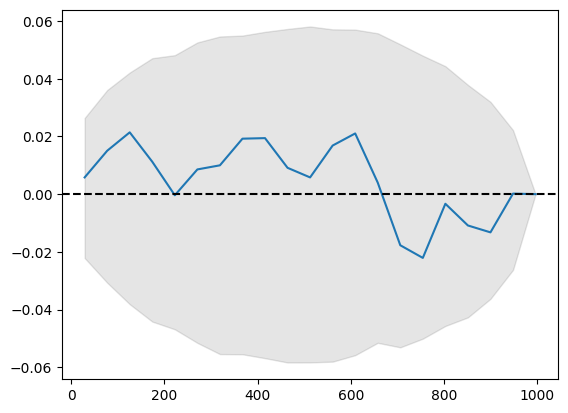

In [447]:
# finally deviation from median ecdf 

plt.plot(mids, vals - median_ecdf)
plt.fill_between(mids, low_ecdf - median_ecdf, high_ecdf - median_ecdf, color='k', alpha=0.1)
plt.axhline(0.0, c='k', ls='--')

# Test on uniform distribution

In [59]:
from numpy.random import randint

In [66]:
ranks_example = randint(low=0, high=52, size=(500,))

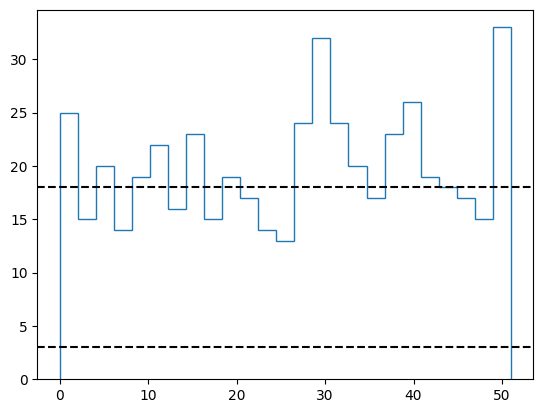

In [68]:
_, bins, _ = plt.hist(ranks_example, bins=25, histtype='step')
p1 = binom.ppf(0.005, n=500, p=52**-1)
p2 = binom.ppf(0.995, n=500, p=52**-1)
plt.axhline(p1, c='k', ls='--')
plt.axhline(p2, c='k', ls='--')

In [70]:
binom.ppf(0.005, n=500, p=52**-1)

np.float64(3.0)

In [71]:
500 / 25 

20.0